In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

from numba import njit

import matplotlib.pyplot as plt

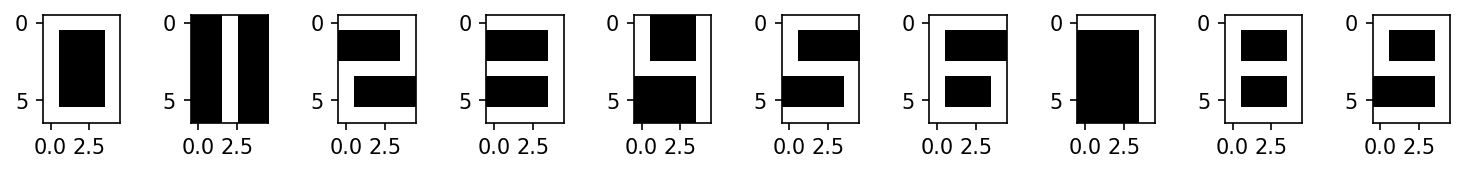

In [2]:
nums_mtrx = np.loadtxt(Path('/mnt/HDD500GB/Data/development/jupyterLab/data/numbers_7x5.txt'))

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

img_shape = (7, 5)
img_size = 35

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')

plt.tight_layout()
plt.show()

In [3]:
columns = [f'c{n}' for n in range(img_size)]
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

df = pd.DataFrame(columns=columns+['class'])

for i in range(10):
    new_row = dict(zip(columns, nums_mtrx[i]))
    new_row['class'] = classes[i]

    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.5, img_size)

        new_row = dict(zip(columns, noised_num))
        new_row['class'] = classes[i]

        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

In [4]:
features_columns = columns
x_train = np.array(df[features_columns])

In [5]:
@njit(fastmath=True)
def calc_forces(x: np.ndarray, p: np.ndarray, a: float) -> None:
    nn = p.shape[0]
    nx = x.shape[0]
    
    forces: np.ndarray = np.zeros(p.shape, np.float32)
    
    for i in range(nn):
        dx = np.sum(np.square(x - p[i]), axis=1).reshape((nx, 1))
        attr_force = a / (dx + 1) * (x - p[i])
        
        dp = np.sum(np.square(p[i] - p), axis=1).reshape((nn, 1))
        separation_force = a / (dp + 1) * (p[i] - p)
        
        mean_attr_force = 1 / nx * np.sum(attr_force, axis=0)
        mean_sep_force = 1 / nn * np.sum(separation_force, axis=0)

        forces[i] = mean_attr_force + mean_sep_force
        
    return forces

In [6]:
class SelfOrganizingMap:
    def __init__(self, n, a) -> None:
        self.n: int = n
        self.p: np.ndarray = None
        self.a: float = a

    def _init_weights(self, data: np.ndarray):
        self.p = np.random.uniform(-1, 1, (self.n, data.shape[1]))

    def train(self, x_train: np.ndarray, lr: float, batch_size: int, max_epoch: int) -> None:
        n = x_train.shape[0]

        self._init_weights(x_train)

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n // batch_size):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                forces = calc_forces(x_train[batch_idxs].astype(np.float32), self.p.astype(np.float32), self.a)

                self.p += lr * forces

In [84]:
m = 10
n = m * m

heighbourhood_size = 1.0

learning_rate = 1.0
batch_size = 16
max_epoch = 100

model = SelfOrganizingMap(n, heighbourhood_size)
model.train(x_train, learning_rate, batch_size, max_epoch)

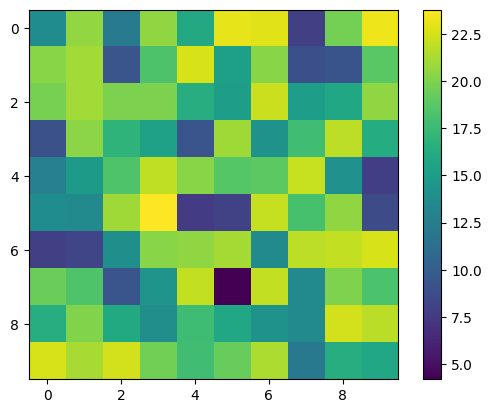

In [85]:
y = np.zeros(model.n)

for x in x_train[0:100:10]:
    dx = np.square(model.p - x)
    q = 1 / (np.sum(dx, axis=1) + 1)
    
    for i in range(model.n):
        dp = np.sum(np.square(model.p[i] - model.p), axis=1)
        y[i] += np.sum(q / (dp + 1))
        
img = plt.imshow(y.reshape(m, m))
plt.colorbar(img)
plt.show()

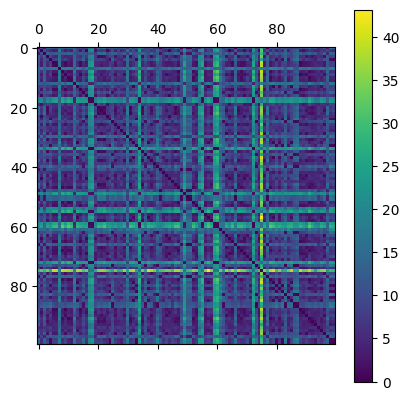

In [86]:
dist2_mtrx = np.zeros((n, n))

for i, pi in enumerate(model.p):
    for j, pj in enumerate(model.p):
        dist2_mtrx[i][j] = np.sum(np.square(pi - pj))

img = plt.matshow(dist2_mtrx)
plt.colorbar(img)
plt.show()

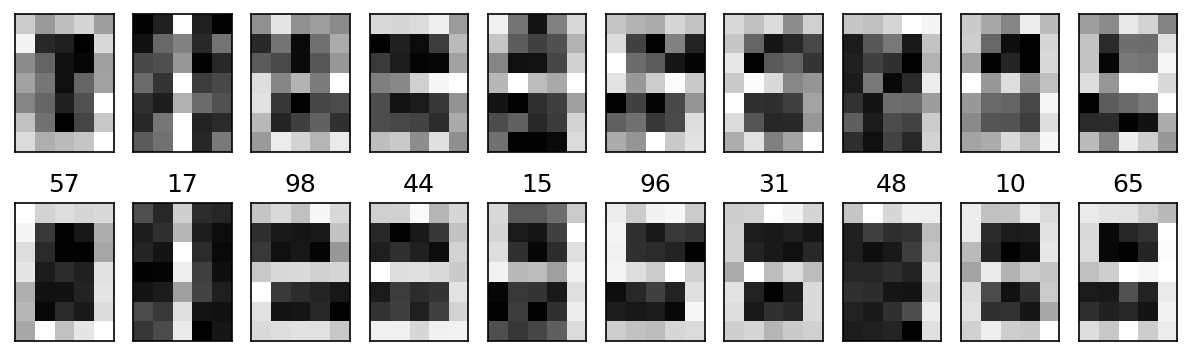

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(3)

idxs = range(0, 100, 10)

noise_size = 1.0

for i, idx in enumerate(idxs):
    x = x_train[idx] + np.random.uniform(0, noise_size, img_size)
    
    winner_idx = np.argmin(np.sum(np.square(x-model.p), axis=1))

    axes[0, i].imshow(x.reshape(img_shape), cmap='binary_r')
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])

    axes[1, i].imshow(model.p[winner_idx].reshape(img_shape), cmap='binary_r')
    axes[1, i].set_title(winner_idx)
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])

plt.show()